In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import *
import cv2
import numpy as np
import random 
import os
import pandas as pd
import warnings
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D,
    Concatenate, Activation, Multiply, Reshape,
    GlobalAveragePooling2D, Dense, AveragePooling2D, Lambda, BatchNormalization
)
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers


In [ ]:
import tensorflow as tf

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
    directory=r"D:\Akshaya\Resampled prostate images with reduced images - Copy\train",
    target_size=(224, 224),
    batch_size=16,
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    directory=r"D:\Akshaya\Resampled prostate images with reduced images - Copy\Valid",
    target_size=(224, 224),
    batch_size=16,
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    directory=r"D:\Akshaya\Resampled prostate images with reduced images - Copy\test",
    target_size=(224, 224),
    batch_size=16,
    shuffle=False  # don't shuffle
)

print("Train classes:", train_generator.class_indices)
print("Validation classes:", val_generator.class_indices)
print("Test classes:", test_generator.class_indices)


Found 11684 images belonging to 4 classes.
Found 2939 images belonging to 4 classes.
Found 2854 images belonging to 4 classes.
Train classes: {'0': 0, '1': 1, '2': 2, '3': 3}
Validation classes: {'0': 0, '1': 1, '2': 2, '3': 3}
Test classes: {'0': 0, '1': 1, '2': 2, '3': 3}


In [ ]:
""" LiverNet model definition """
def aspp(x,num_fil,input_shape,out_stride):
    
    b0=Conv2D(num_fil,(1,1),padding="same",use_bias=False)(x)
    b0=BatchNormalization()(b0)
    b0=Activation("relu")(b0)

    b1=DepthwiseConv2D((3,3),dilation_rate=(2,2),padding="same",use_bias=False)(x)
    b1=BatchNormalization()(b1)
    b1=Activation("relu")(b1)
    b1=Conv2D(num_fil,(1,1),padding="same",dilation_rate = (1,1), use_bias=False)(x)
    b1=BatchNormalization()(b1)
    b1=Activation("relu")(b1)

    b2=DepthwiseConv2D((3,3),dilation_rate=(3,3),padding="same",use_bias=False)(x)
    b2=BatchNormalization()(b2)
    b2=Activation("relu")(b2)
    b2=Conv2D(num_fil, (1,1) , padding="same", use_bias=False)(x)
    b2=BatchNormalization()(b2)
    b2=Activation("relu")(b2)	

    b3=DepthwiseConv2D((3,3),dilation_rate=(6,6),padding="same",use_bias=False)(x)
    b3=BatchNormalization()(b3)
    b3=Activation("relu")(b3)
    b3=Conv2D(num_fil, (1,1) , padding="same", use_bias=False)(x)
    b3=BatchNormalization()(b2)
    b3=Activation("relu")(b2)	

    b5=DepthwiseConv2D((3,3),dilation_rate=(8,8),padding="same",use_bias=False)(x)
    b5=BatchNormalization()(b5)
    b5=Activation("relu")(b5)
    b5=Conv2D(num_fil,(1,1),padding="same",use_bias=False)(b5)
    b5=BatchNormalization()(b5)
    b5=Activation("relu")(b5)


    out_shape=int(input_shape[0]/out_stride)
    b4=AveragePooling2D(pool_size=(out_shape,out_shape))(x)
    b4=Conv2D(num_fil,(1,1),padding="same",use_bias=False)(b4)
    b4=BatchNormalization()(b4)
    b4=Activation("relu")(b4)
    b4 = UpSampling2D(
    size=(out_shape, out_shape), interpolation="bilinear")(b4)

    x=Concatenate()([b4,b0,b1,b2,b3,b5])
    
    x = tf.keras.layers.Conv2D(num_fil , kernel_size = (1,1) , padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    return x


def normalize_data_format(value):
    if value is None:
        value = K.image_data_format()
    data_format = value.lower()
    if data_format not in {'channels_first', 'channels_last'}:
        raise ValueError('The `data_format` argument must be one of '
                         '"channels_first", "channels_last". Received: ' +
                         str(value))
    return data_format


def cbam_block(cbam_feature, ratio=8):
    cbam_feature = channel_attention(cbam_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature


def channel_attention(input_feature, ratio=8):
    
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]
    
    shared_layer_one = Dense(channel//ratio,
                             activation='relu',
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    shared_layer_two = Dense(channel,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    
    avg_pool = GlobalAveragePooling2D()(input_feature)    
    avg_pool = Reshape((1,1,channel))(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel)
    avg_pool = shared_layer_one(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel//ratio)
    avg_pool = shared_layer_two(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel)
    
    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1,1,channel))(max_pool)
    assert max_pool.shape[1:] == (1,1,channel)
    max_pool = shared_layer_one(max_pool)
    assert max_pool.shape[1:] == (1,1,channel//ratio)
    max_pool = shared_layer_two(max_pool)
    assert max_pool.shape[1:] == (1,1,channel)
    
    cbam_feature = Add()([avg_pool,max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)
    cbam_feature = Activation('sigmoid')(cbam_feature)

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)
    
    return multiply([input_feature, cbam_feature])


def spatial_attention(input_feature):

    kernel_size = 7
    
    if K.image_data_format() == "channels_first":
        channel = input_feature.shape[1]
        cbam_feature = Permute((2,3,1))(input_feature)
    else:
        channel = input_feature.shape[-1]
        cbam_feature = input_feature
    
    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
    assert avg_pool.shape[-1] == 1
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
    assert max_pool.shape[-1] == 1
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    assert concat.shape[-1] == 2
    cbam_feature = Conv2D(filters = 1,
                    kernel_size=kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)(concat)	
    assert cbam_feature.shape[-1] == 1
    
    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)
        
    return multiply([input_feature, cbam_feature])


def residual_block(y, nb_channels, _strides=(1, 1), _project_shortcut=False):

  shortcut = y
  y = Conv2D(nb_channels//4, kernel_size=(3, 3), strides=_strides, padding='same')(y)
  y = BatchNormalization()(y)
  y = LeakyReLU()(y)

  y = Conv2D(nb_channels, kernel_size=(3, 3), strides=(1, 1), padding='same')(y)
  y = BatchNormalization()(y)

  if _project_shortcut or _strides != (1, 1):
    shortcut = Conv2D(nb_channels, kernel_size=(1, 1), strides=_strides, padding='same')(shortcut)
    shortcut = BatchNormalization()(shortcut)

  y = add([shortcut, y])
  y = LeakyReLU()(y)

  return y


class BilinearUpsampling(Layer):

    
    def __init__(self, upsampling=(2, 2), data_format=None, **kwargs):

        super(BilinearUpsampling, self).__init__(**kwargs)
        self.data_format = normalize_data_format(data_format)
        self.upsampling = conv_utils.normalize_tuple(upsampling, 2, 'size')
        self.input_spec = InputSpec(ndim=4)

    def compute_output_shape(self, input_shape):
        height = self.upsampling[0] * \
            input_shape[1] if input_shape[1] is not None else None
        width = self.upsampling[1] * \
            input_shape[2] if input_shape[2] is not None else None
        return (input_shape[0],
                height,
                width,
                input_shape[3])

    def call(self, inputs):
        return tf.image.resize(inputs, (int(inputs.shape[1]*self.upsampling[0]),
                                                   int(inputs.shape[2]*self.upsampling[1])))

    def get_config(self):
        config = {'size': self.upsampling,
                  'data_format': self.data_format}
        base_config = super(BilinearUpsampling, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


def create_model():

    dropRate = 0.3
    
    init = Input((224,224,3))

    x = Conv2D(32, (3, 3), activation=None, padding='same')(init) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(32, (3, 3), activation=None, padding='same')(x) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x1 = MaxPooling2D((3,3),(2,2),padding='same')(x)

    
    x = Conv2D(64, (3, 3), activation=None, padding='same')(x1)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = cbam_block(x)
    x = residual_block(x, 64)
    x2 = MaxPooling2D((3,3),(2,2), padding='same')(x)
    
    x = Conv2D(128, (3, 3), activation=None, padding='same')(x2)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = cbam_block(x)
    x = residual_block(x, 128)
    x3 = MaxPooling2D((3,3),(2,2),padding='same')(x)
    
    x1_aspp = aspp(x1,32,(112,112),1)
    x2_aspp = aspp(x2,64,(56,56),1)
    x3_aspp = aspp(x3,128,(28,28),1)

    ginp1 = UpSampling2D(size=(2, 2), interpolation='bilinear')(x1_aspp)
    ginp2 = UpSampling2D(size=(4, 4), interpolation='bilinear')(x2_aspp)
    ginp3 = UpSampling2D(size=(8, 8), interpolation='bilinear')(x3_aspp)
    
    hypercolumn = Concatenate()([ginp1, ginp2, ginp3]) 
    gap = GlobalAveragePooling2D()(hypercolumn)

    x = Dense(256, activation=None)(gap)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropRate)(x)
    
    x = Dense(256, activation=None)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    y = Dense(4, activation='softmax')(x)
    
    model = Model(init, y)
    return model


model = create_model()

for layer in model.layers:
    if hasattr(layer, 'kernel_regularizer'):
        layer.kernel_regularizer= regularizers.l2(0.03)
    
    if hasattr(layer, 'bias_regularizer'):
        layer.bias_regularizer= regularizers.l2(0.03)


model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ["acc"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_78 (Conv2D)              (None, 224, 224, 32) 896         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_104 (BatchN (None, 224, 224, 32) 128         conv2d_78[0][0]                  
__________________________________________________________________________________________________
activation_104 (Activation)     (None, 224, 224, 32) 0           batch_normalization_104[0][0]    
____________________________________________________________________________________________

In [ ]:

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)


steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = val_generator.samples // val_generator.batch_size


callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='livernet_best.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]


history = model.fit(
    train_generator,
    epochs=65,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)


Epoch 1/65
730/730 [==============================] - 179s 235ms/step - loss: 0.7413 - accuracy: 0.6700 - val_loss: 0.5547 - val_accuracy: 0.7500

Epoch 00001: val_accuracy improved from -inf to 0.75000, saving model to livernet_best.keras


C:\Users\NITK\anaconda3\envs\Shyam_Lal\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/65
730/730 [==============================] - 170s 233ms/step - loss: 0.5818 - accuracy: 0.7395 - val_loss: 0.8973 - val_accuracy: 0.6889

Epoch 00002: val_accuracy did not improve from 0.75000
Epoch 3/65
730/730 [==============================] - 170s 233ms/step - loss: 0.5334 - accuracy: 0.7650 - val_loss: 0.6949 - val_accuracy: 0.7193

Epoch 00003: val_accuracy did not improve from 0.75000
Epoch 4/65
730/730 [==============================] - 170s 233ms/step - loss: 0.4985 - accuracy: 0.7822 - val_loss: 0.3942 - val_accuracy: 0.8241

Epoch 00004: val_accuracy improved from 0.75000 to 0.82411, saving model to livernet_best.keras
Epoch 5/65
730/730 [==============================] - 170s 233ms/step - loss: 0.4604 - accuracy: 0.7993 - val_loss: 0.4215 - val_accuracy: 0.8245

Epoch 00005: val_accuracy improved from 0.82411 to 0.82445, saving model to livernet_best.keras
Epoch 6/65
730/730 [==============================] - 170s 233ms/step - loss: 0.4413 - accuracy: 0.8105 - val_

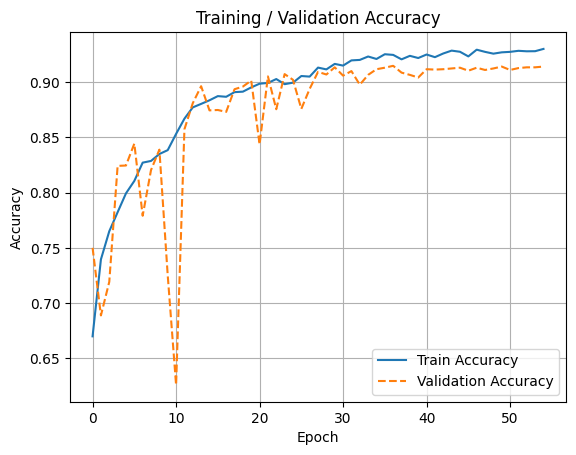

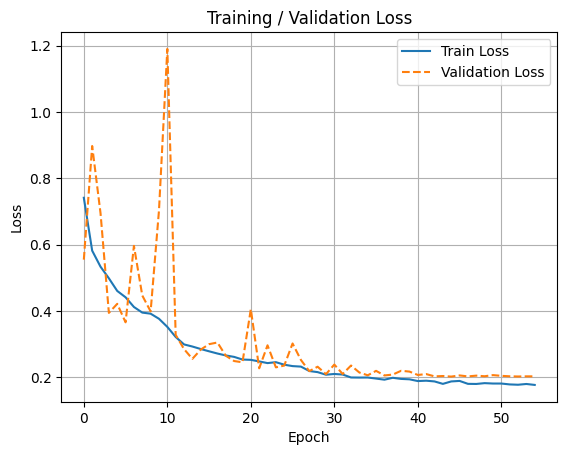

In [12]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'], '--')
plt.legend(['Train Accuracy', 'Validation Accuracy'])
plt.title('Training / Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], '--')
plt.legend(['Train Loss', 'Validation Loss'])
plt.title('Training / Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


In [13]:
# vgg16model.load_weights("./cropModel.h5")
class_labels = test_generator.class_indices
oriningal_test_classes = test_generator.labels
print(class_labels)
print("Original test classes")
print(oriningal_test_classes)

Y_pred =model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
print("Predicted test classes")
print(y_pred)

{'0': 0, '1': 1, '2': 2, '3': 3}
Original test classes
[0 0 0 ... 3 3 3]
Predicted test classes
[0 0 0 ... 3 3 3]


In [14]:
print('Accuracy {}'.format(accuracy_score(y_true=test_generator.labels, y_pred=y_pred)))
print('F1 {}'.format(f1_score(y_true=test_generator.labels, y_pred=y_pred,average = "macro")))
print('precision {}'.format(precision_score(y_true=test_generator.labels, y_pred=y_pred,average = "macro")))
print('recall {}'.format(recall_score(y_true=test_generator.labels, y_pred=y_pred,average = "macro")))

print('jaccard {}'.format(jaccard_score(y_true=test_generator.labels, y_pred=y_pred,average = "macro")))
print('classification_report\n {}'.format(classification_report(y_true=test_generator.labels, y_pred=y_pred)))
print('\n\n')
cm = confusion_matrix(y_true=test_generator.labels, y_pred=y_pred)
print(cm)

Accuracy 0.918009810791871
F1 0.9181144012468213
precision 0.9187171310042271
recall 0.9180911330049262
jaccard 0.8537741456541167
classification_report
               precision    recall  f1-score   support

           0       0.87      0.91      0.89       754
           1       0.87      0.82      0.84       700
           2       0.93      0.94      0.94       700
           3       1.00      1.00      1.00       700

    accuracy                           0.92      2854
   macro avg       0.92      0.92      0.92      2854
weighted avg       0.92      0.92      0.92      2854




[[689  54  10   1]
 [ 88 575  37   0]
 [ 12  32 656   0]
 [  0   0   0 700]]
